In [53]:
import os
import scipy.io as sio
import numpy as np
import glob
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import tarfile
import scipy
import PIL
import random 
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split
import shutil


## Importing the data

In [2]:
DATA_PATH = "/home/perr/Downloads/ex3/"
PATH="/home/perr/Downloads/ex3/102flowers/"

In [3]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # ?????? (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [4]:
df["Id"]=PATH+df["Id"].astype(str)

In [5]:
df.head()

,Id,Category
0,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76
1,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76
2,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76
3,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76
4,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76


In [6]:
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(DATA_PATH)

print(os.listdir(DATA_PATH+'jpg')[:5])

['image_05750.jpg', 'image_04720.jpg', 'image_03359.jpg', 'image_04809.jpg', 'image_07098.jpg']


### Split to train-test-validation

In [7]:
random.seed(100)
train_files, test_files, train_labels, test_labels= \
    train_test_split(df['Id'], df['Category'], test_size=0.25, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)

train_files['Category'] = train_labels
test_files['Category'] = test_labels


train_files, val_files, train_labels, val_labels = \
    train_test_split(train_files['Id'], train_files['Category'], test_size=2047, random_state=42, stratify=train_files['Category'])

train_files = pd.DataFrame(train_files)
val_files = pd.DataFrame(val_files)
train_files['Category'] = train_labels
val_files['Category'] = val_labels

val_files.shape, test_files.shape, train_files.shape

((2047, 2), (2048, 2), (4094, 2))

In [8]:
train_files.reset_index(inplace=True)
test_files.reset_index(inplace=True)
val_files.reset_index(inplace=True)
test_files

,index,Id,Category
0,2712,/home/perr/Downloads/ex3/102flowers/jpg/image_...,57
1,179,/home/perr/Downloads/ex3/102flowers/jpg/image_...,76
2,3979,/home/perr/Downloads/ex3/102flowers/jpg/image_...,50
3,7962,/home/perr/Downloads/ex3/102flowers/jpg/image_...,100
4,5295,/home/perr/Downloads/ex3/102flowers/jpg/image_...,69
...,...,...,...
2043,6431,/home/perr/Downloads/ex3/102flowers/jpg/image_...,8
2044,6335,/home/perr/Downloads/ex3/102flowers/jpg/image_...,49
2045,3586,/home/perr/Downloads/ex3/102flowers/jpg/image_...,71
2046,8031,/home/perr/Downloads/ex3/102flowers/jpg/image_...,101


In [9]:
path="/home/perr/Downloads/ex3/seed100/"
class_num = 102
class_names =[i for i in range(0,class_num)]

In [10]:
def create_folders(data_name,class_names):
# loop over the class labels
    for label in class_names:
        label_path = os.path.join(path,data_name, str(label))
        if not os.path.isdir(label_path):
            # create a folder for that class
            os.chdir(os.path.join(path,data_name)) # enable to add sub folder to the main folder
            os.mkdir(str(label))


In [11]:
path

'/home/perr/Downloads/ex3/seed100/'

In [12]:
def copy_pic_to_folders(df_with_path_dir,data_name,path):
    main_path=os.path.join(path,data_name)
    image_paths = df_with_path_dir["Id"]
    labels=df_with_path_dir["Category"]
    for i,label in enumerate(labels):
        cur_path=os.path.join(main_path, str(label),)
        os.system("cp " + image_paths[i] + " " +cur_path )
        #shutil.copy(image_paths[i] ,cur_path)

In [13]:
create_folders("train",class_names)
copy_pic_to_folders(train_files,"train",path)
create_folders("test",class_names)
copy_pic_to_folders(test_files,"test",path)
create_folders("validation",class_names)
copy_pic_to_folders(val_files,"validation",path)


## loading the data

In [14]:
#Generate batches of tensor image data with real-time data augmentation.

In [15]:
train_dir=os.path.join(path,"train")
validation_dir=os.path.join(path,"validation")
test_dir=os.path.join(path,"test")

In [16]:
validation_dir

'/home/perr/Downloads/ex3/seed100/validation'

In [54]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4094 files belonging to 102 classes.
Found 2047 files belonging to 102 classes.
Found 2048 files belonging to 102 classes.


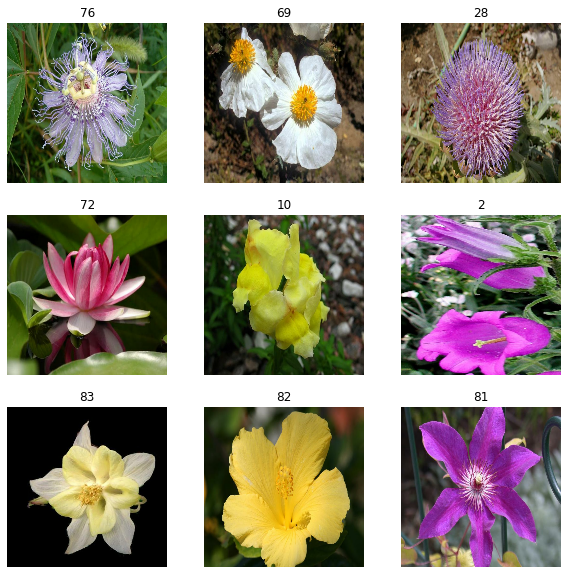

In [18]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
train_batches = tf.data.experimental.cardinality(train_dataset)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_batches = tf.data.experimental.cardinality(test_dataset)
train_dataset = train_dataset.take(train_batches)
val_dataset = validation_dataset.take(val_batches)
test_dataset = test_dataset.take(test_batches)



In [20]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 128
Number of validation batches: 64
Number of test batches: 64


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomCrop(height=140, width=140),
  tf.keras.layers.RandomWidth(factor=0.4),
  tf.keras.layers.RandomZoom(height_factor=(0.01, 0.1), width_factor=(0.01, 0.2))])

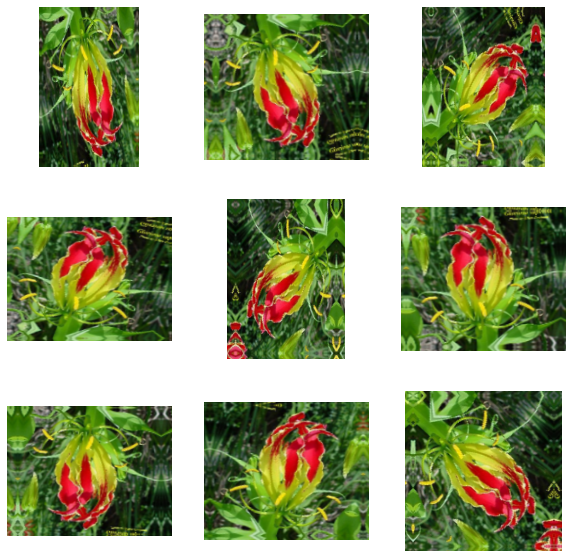

In [23]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## MobileNet V2

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [27]:
base_model.trainable = False

In [55]:
#base_model.summary()

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [30]:
prediction_layer = tf.keras.layers.Dense(102,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


In [31]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
len(model.trainable_variables)


2

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

64/64 [==============================] - 9s 110ms/step - loss: 5.1121 - accuracy: 0.0073


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.11
initial accuracy: 0.01


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
128/128 [==============================] - 25s 174ms/step - loss: 4.8469 - accuracy: 0.0291 - val_loss: 4.1507 - val_accuracy: 0.0948
Epoch 2/10
128/128 [==============================] - 22s 171ms/step - loss: 3.9987 - accuracy: 0.1085 - val_loss: 3.5767 - val_accuracy: 0.2184
Epoch 3/10
128/128 [==============================] - 21s 163ms/step - loss: 3.3603 - accuracy: 0.2318 - val_loss: 3.1293 - val_accuracy: 0.3332
Epoch 4/10
128/128 [==============================] - 21s 162ms/step - loss: 2.9581 - accuracy: 0.3234 - val_loss: 2.7667 - val_accuracy: 0.4270
Epoch 5/10
128/128 [==============================] - 21s 167ms/step - loss: 2.5984 - accuracy: 0.4287 - val_loss: 2.4842 - val_accuracy: 0.4934
Epoch 6/10
128/128 [==============================] - 20s 159ms/step - loss: 2.2944 - accuracy: 0.4827 - val_loss: 2.2528 - val_accuracy: 0.5432
Epoch 7/10
128/128 [==============================] - 20s 154ms/step - loss: 2.0656 - accuracy: 0.5354 - val_loss: 2.0735 - val_ac

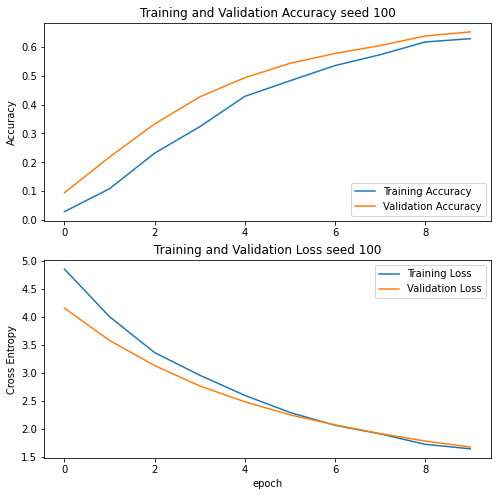

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy seed 100')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss seed 100')
plt.gcf().savefig('Training and Validation Loss seed 100')

plt.xlabel('epoch')
plt.show()

In [38]:
os.getcwd()

'/home/perr/Downloads'

In [39]:
base_model.trainable = True


In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 85

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [41]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
len(model.trainable_variables)


73

In [43]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Fine-Tuning

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
128/128 [==============================] - 34s 232ms/step - loss: 1.1252 - accuracy: 0.6988 - val_loss: 1.0211 - val_accuracy: 0.7255
Epoch 11/20
128/128 [==============================] - 29s 225ms/step - loss: 0.9222 - accuracy: 0.7426 - val_loss: 0.9166 - val_accuracy: 0.7513
Epoch 12/20
128/128 [==============================] - 31s 239ms/step - loss: 0.8561 - accuracy: 0.7543 - val_loss: 0.8430 - val_accuracy: 0.7680
Epoch 13/20
128/128 [==============================] - 31s 240ms/step - loss: 0.7590 - accuracy: 0.7814 - val_loss: 0.7954 - val_accuracy: 0.7763
Epoch 14/20
128/128 [==============================] - 30s 234ms/step - loss: 0.7081 - accuracy: 0.8002 - val_loss: 0.7568 - val_accuracy: 0.7973
Epoch 15/20
128/128 [==============================] - 30s 238ms/step - loss: 0.6450 - accuracy: 0.8124 - val_loss: 0.7279 - val_accuracy: 0.7968
Epoch 16/20
128/128 [==============================] - 29s 228ms/step - loss: 0.6117 - accuracy: 0.8227 - val_loss: 0.6926 -

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

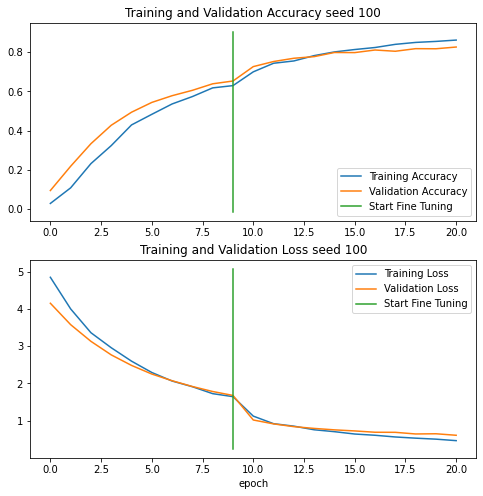

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy seed 100')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss seed 100')
plt.gcf().savefig('Training and Validation Loss and accuracy after tunning seed 100')

plt.xlabel('epoch')
plt.show()

## Hyper parameter tuning

Epoch 1/30
128/128 [==============================] - 29s 228ms/step - loss: 0.4510 - accuracy: 0.8617 - val_loss: 0.6119 - val_accuracy: 0.8227 - lr: 1.0000e-05
Epoch 2/30
128/128 [==============================] - 29s 226ms/step - loss: 0.4238 - accuracy: 0.8745 - val_loss: 0.5869 - val_accuracy: 0.8363 - lr: 1.0000e-05
Epoch 3/30
128/128 [==============================] - 29s 226ms/step - loss: 0.4101 - accuracy: 0.8832 - val_loss: 0.5810 - val_accuracy: 0.8339 - lr: 1.0000e-05
Epoch 4/30
128/128 [==============================] - 30s 232ms/step - loss: 0.3746 - accuracy: 0.8842 - val_loss: 0.5719 - val_accuracy: 0.8349 - lr: 1.0000e-05
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8942
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
128/128 [==============================] - 29s 228ms/step - loss: 0.3607 - accuracy: 0.8942 - val_loss: 0.5769 - val_accuracy: 0.8422 - lr: 1.0000e-05
Epoch 6/30
128/128 [=========

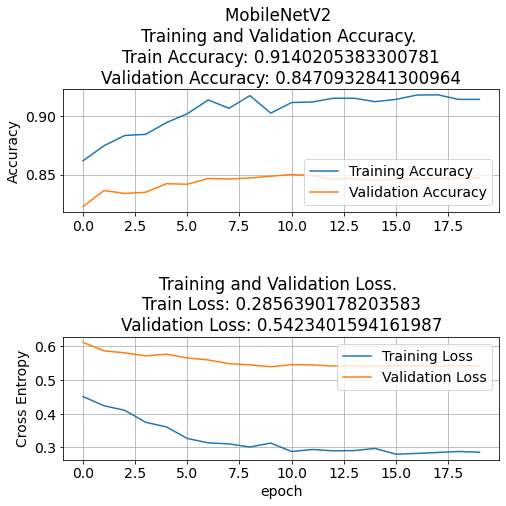

In [47]:
epochs = 30

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
#fit the model
history = model.fit(train_dataset, 
                    epochs=epochs,
                    validation_data = val_dataset,
                    callbacks=[early_stopper, reduce_lr])
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.gcf().savefig('Training and Validation Loss and accuracy final seed 100')

plt.show()

In [51]:
len(base_model.layers)

154

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [49]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

64/64 [==============================] - 6s 98ms/step - loss: 0.5293 - accuracy: 0.8442
Test accuracy : 0.84423828125
